<a href="https://colab.research.google.com/github/ljrn8/QuickNotebooks/blob/main/blood_cells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# import cv2 # opencv
import matplotlib.pyplot as plt

# Loading in Blood Cell dataset from kaggle

In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from google.colab import drive
drive.mount('/content/drive')
!cd /content/drive/MyDrive/
!mkdir ~/.kaggle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [15]:
!kaggle datasets list -s 'blood cells'

ref                                                       title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
paultimothymooney/blood-cells                             Blood Cell Images                              108MB  2018-04-21 21:06:13          32121        765  0.7058824        
saurabhshahane/in-hospital-mortality-prediction           In Hospital Mortality Prediction               136KB  2021-09-03 16:04:57           3727        103  0.9411765        
kmader/malaria-bounding-boxes                             Malaria Bounding Boxes                           4GB  2019-05-09 13:37:54           3336        117  0.75             
alexandervc/single-cell-rna-seq-nestorova2016-mouse-hspc  Single Cell RNA seq Nestorova2016 Mouse HSPC    28MB  202

In [20]:
!kaggle datasets download -d 'paultimothymooney/blood-cells'

100% 108M/108M [00:03<00:00, 44.6MB/s]
100% 108M/108M [00:03<00:00, 35.5MB/s]


In [21]:
!unzip blood-cells.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8050.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8167.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8283.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8324.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8379.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8577.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8587.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8655.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8701.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_872.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8864.jpeg  
  inflating: dataset2-mast

In [24]:
# !tree dataset2-master/ --filelimit 10

/bin/bash: tree: command not found


In [25]:
base_dir = '/content/dataset2-master/dataset2-master/images/'

# Looking at the data

sample image shape:  (240, 320, 3)


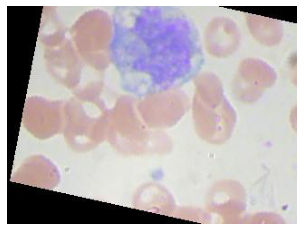

In [28]:
fname = os.listdir(base_dir + 'TRAIN/MONOCYTE/')[0]
sample_image = plt.imread(base_dir + 'TRAIN/MONOCYTE/' + fname)
print('sample image shape: ', sample_image.shape)
plt.imshow(sample_image)
plt.axis('off')
plt.show()

MONOCYTE


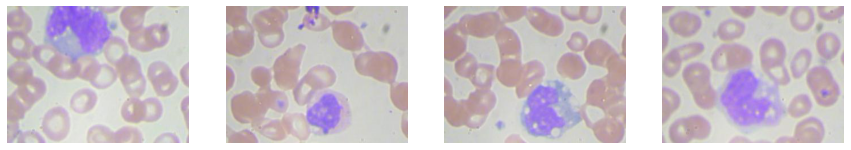

LYMPHOCYTE


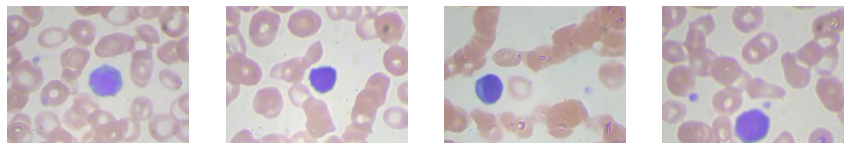

EOSINOPHIL


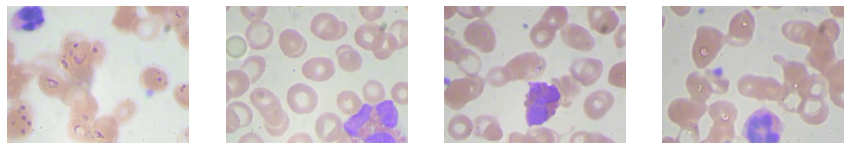

NEUTROPHIL


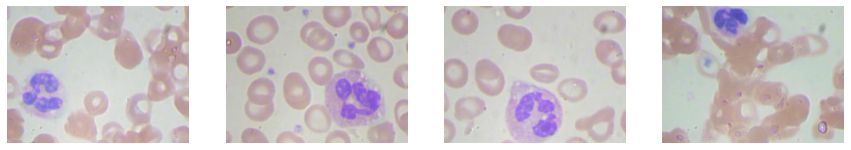

In [29]:
def peak(path):
    ''' looks at the first 4 images '''
    fig, axs = plt.subplots(1,4, figsize=(15,7))
    for count, (ax, filename) in enumerate(zip(axs, os.scandir(path))):
        image = plt.imread(filename.path)
        ax.imshow(image)
        ax.axis('off')
        if count == 4:
            break
    plt.show()

subcats = ['MONOCYTE', 'LYMPHOCYTE', 'EOSINOPHIL', 'NEUTROPHIL']
for subcat in subcats:
    print(subcat)
    peak(base_dir + 'TEST_SIMPLE/' + subcat + '/')   

# Preprocessing & Setup

In [ ]:
batch = 32

test_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir + 'TEST/', seed=0, batch_size=batch
)
valid_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir + 'TRAIN/', seed=0, batch_size=batch,
    validation_split=0.2, subset="validation", 
)
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir + 'TRAIN/', seed=0, batch_size=batch,
    validation_split=0.2, subset="training", 
)
# ds: full dataset
ds = test_ds.concatenate(train_ds).concatenate(valid_ds)

Found 2487 files belonging to 4 classes.
Found 9957 files belonging to 4 classes.
Using 1991 files for validation.
Found 9957 files belonging to 4 classes.
Using 7966 files for training.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(240, 320),
  layers.Rescaling(1./255.)
])
ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
            num_parallel_calls=AUTOTUNE)
ds = ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)

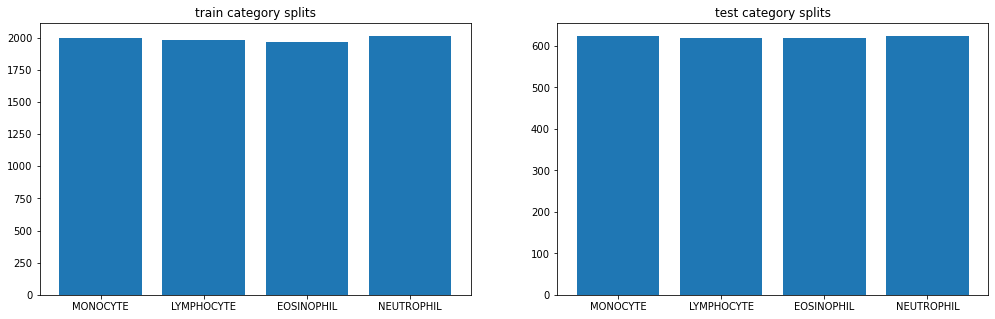

In [ ]:
def plot_categories(ds, categories, ax=plt):
    labels_ds = ds.map(lambda x, y: y)
    labels_np = np.concatenate(list(labels_ds.as_numpy_iterator()))
    uniq, counts = np.unique(labels_np, return_counts=True)
    ax.bar(categories, counts)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))
ax1.set_title('train category splits')
plot_categories(train_ds, subcats, ax=ax1)
ax2.set_title('test category splits')
plot_categories(test_ds, subcats, ax=ax2)
plt.show()    

# Training

In [ ]:
model = tf.keras.applications.InceptionV3(
    include_top=True,
    weights=None,
    input_shape=[256, 256, 3],
    classes=4,
)
model.compile(
    optimizer=keras.optimizers.Adam(0.01),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=4)
history = model.fit(train_ds, epochs=10, callbacks=[early_stopping_cb], validation_data=valid_ds)

Epoch 1/10
  6/249 [..............................] - ETA: 30:44 - loss: 4.3706 - accuracy: 0.2240

KeyboardInterrupt: 

# TODO 
- read in data first
- value counts